An attempt is now made to understand the firedrake code provided by Professor Onno Bokhove and PGR Yang Lu. Below I managed to switch Onno's code between the sympletic-Euler time scheme and the forward Euler time scheme (one is commented out). Then based on the splitting up of the whole time period 'Tend' given by the array 'tmeas', the code was altered to plot curves in between the periods $[3T_p , 4T_p]$ and $[9T_p , 10T_p]$ where $T_p = \frac{Tend}{10}$.

/home/mm21jd/firedrake/lib/python3.12/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Tend 12.566370614359172
energy 0 0.0
Prior to start time loop. Hallo!
Elapsed time (min): 0.02533911863962809


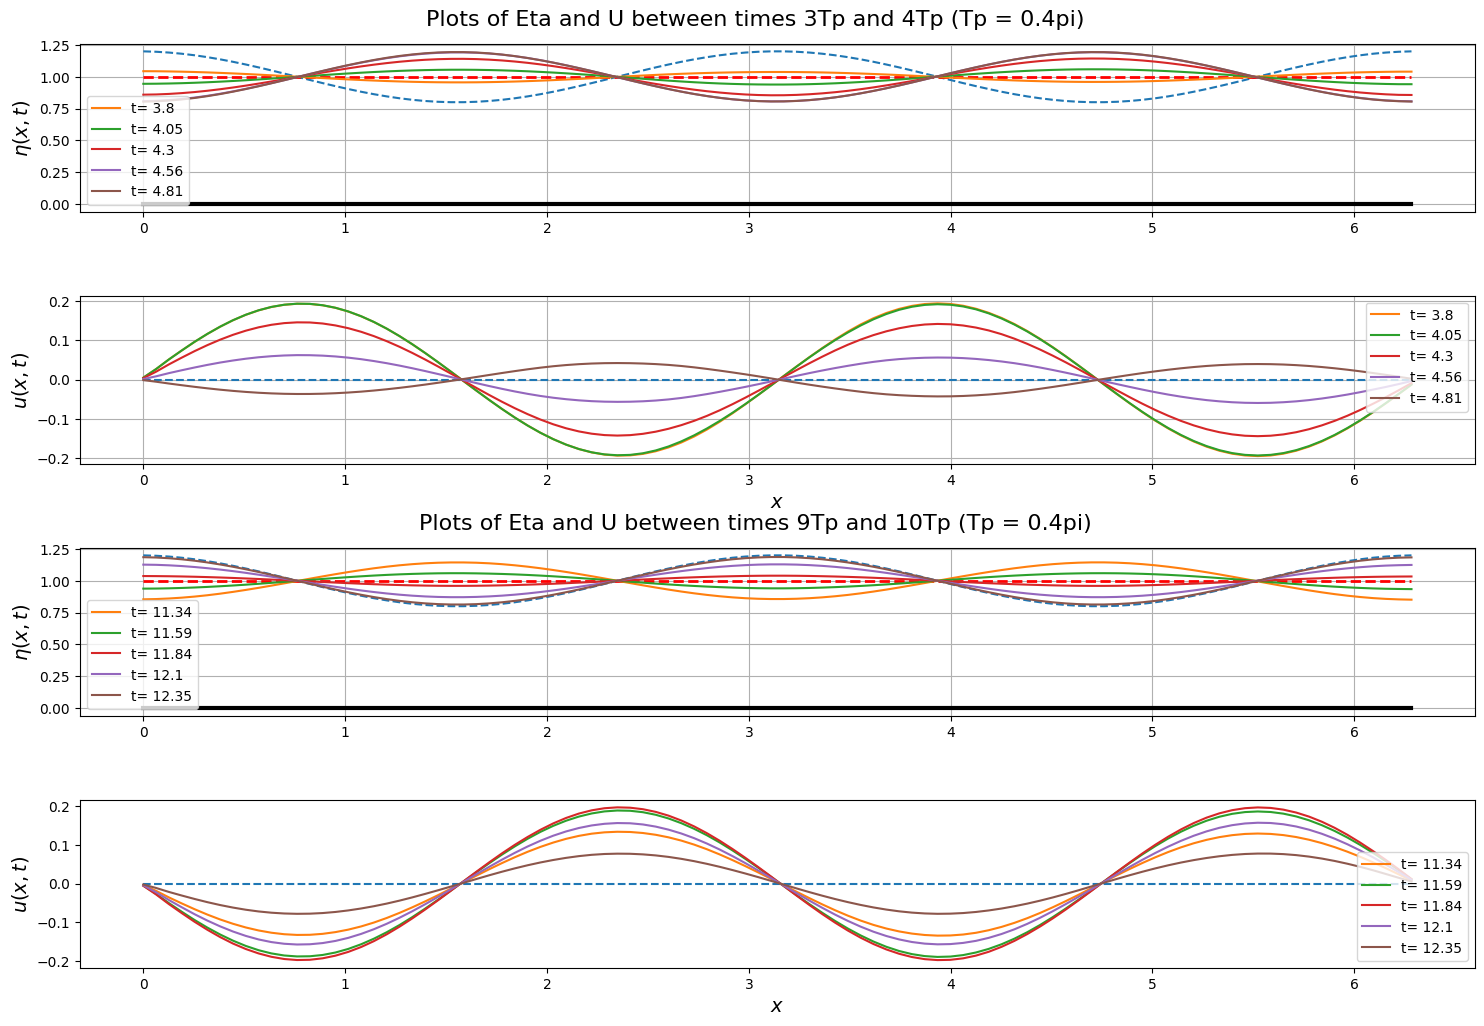

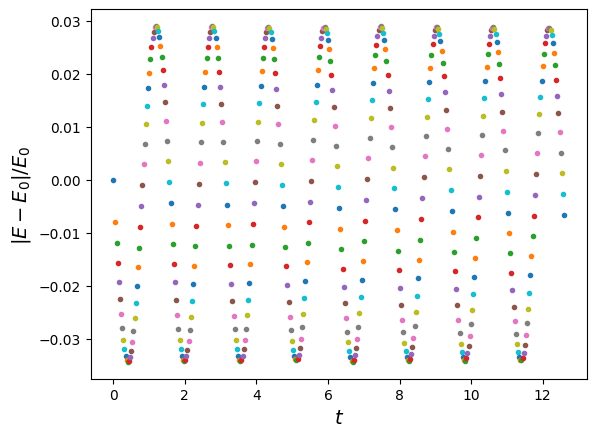

*************** PROGRAM ENDS ******************


In [1]:
from firedrake import *
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import os.path
#import os ONNO 11-02-2023: no idea about opnumthreats warning?
os.environ["OMP_NUM_THREADS"] = "1"

def Hxxtopo(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*conditional(le(W+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12)+Hb*conditional(le(xk12,L1+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)+(H0-slope*(xk12-W))*conditional(le(xk12,W+0.0*xk12),0.0+0.0*xk12,1.0+0.0*xk12)*conditional(le(L1+0.0*xk12,xk12),0.0+0.0*xk12,1.0+0.0*xk12);

def Hxxtopos(H0, W, L1, Hb, slope, xk12, Nb):
 if Nb<3: 
     return H0+0.0*xk12
 else:
     return H0*np.heaviside(W-xk12,0.5)+Hb*np.heaviside(xk12-L1,0.5)+(H0-slope*(xk12-W))*np.heaviside(xk12-W,0.5)*np.heaviside(L1-xk12,0.5);
# conditional(le(x[0],xb),0.0,sb*(x[0]-xb)))


# fdfff cvyy
# Parameters
#
Nbc = 1
if Nbc==1: # standing wave
    mint = 4
    grav = 1
    H0 = 1.0
    Lx = 2.0*np.pi
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 4
    Tend = Nper*2.0*np.pi/omeg
    print('Tend',Tend)
    dt = Tend/1000
    nmea = 11
    tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
    tmease3 = tmeas[3]
    tmease9 = tmeas[9]
    dtmeas = Tend/10
    dtmease = Tend/50
    Nx = 100
    c00 = np.sqrt(grav*H0)
    CFL = 0.5
    dxx = Lx/Nx
    dt = CFL*dxx/np.amax(c00)
    #nmea = 21
    #tmeas = [0.0,Tend/10,2*Tend/10,3*Tend/10,4*Tend/10,5*Tend/10,6*Tend/10,7*Tend/10,8*Tend/10,9*Tend/10,Tend]
elif Nbc==3:
    H0s = 40 # m
    H0 = 1
    Ld = 12
    gravr = 9.81
    grav = gravr/gravr
    Lx = Ld
    L1 = 10
    W = 2
    Hb = 0.1
    U0s = np.sqrt(gravr*H0s)
    slope = (H0-Hb)/(L1-W)
    bslope = 1.0/50.0
    Ls = slope*H0s/bslope
    Ts = Ls/U0s #
    Tps = 6  #
    Tp = Tps/Ts
    omeg = 2*pi/Tp
    print('Ls, Ts',Ls,Ts)
    kw = omeg/np.sqrt(grav*H0)
    As = 1 # m
    Ad = As/H0s
    Cc = grav*Ad*kw/omeg
    Nper = 45
    Tend = Nper*(2.0*np.pi/omeg)
    dt = Tend/1000
    c00 = np.sqrt(grav*H0)
    CFL = 1.0
    Nx = 4000
    dxx = Lx/Nx
    dt = CFL*dxx/np.amax(c00)
    nmea = 40
    tmease = 0.0
    dtmeas = Tend/nmea
else:
    Tend = 0.01*10.0
    Tend= 10
    dt = 0.005
    Lx = 2.0*np.pi
    grav = 1
    H0 = 1
    nmea = 11
    tmease = 0.0
    dtmeas = Tend/10
    # tmeas = [0.0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.10]
    # tmeas = [0,1,2,3,4,5,6,7,8,9,10]
    Nx = 100
nnm = 0  # counter outputs

#
# Mesh
# mesh1d = UnitIntervalMesh(Nx)
mesh1d = IntervalMesh(Nx,Lx)
# 2D mesh: mesh = ExtrudedMesh(mesh1d, layers=Ny)
mesh = mesh1d
#  coords = mesh.coordinates
# 2D mesh and coordinates: coords.dat.data[:,0] = Lx*coords.dat.data[:,0] coords.dat.data = Lx*coords.dat.data
x, = SpatialCoordinate(mesh)

#
# Function spaces
#
nDG = 0
DG0 = FunctionSpace(mesh, "DG", nDG)
eta0 = Function(DG0, name="eta0")
uve0 = Function(DG0, name="uve0")
vve0 = Function(DG0, name="uve0")
eta1 = Function(DG0, name="eta1")
uve1 = Function(DG0, name="uve1")
eta_trial = TrialFunction(DG0)
uve_trial = TrialFunction(DG0)
deta_test = TestFunction(DG0)
duve_test = TestFunction(DG0)
dvve_test = TestFunction(DG0)

#
# We define n to be the built-in FacetNormal object;
# a unit normal vector that can be used in integrals over exterior and interior facets.
# We next define un to be an object which is equal to 
# if this is positive, and zero if this is negative. This will be useful in the upwind terms.
# how to distinguish interior from exterior facets?
#
# wrong etan = 0.5*(dot(u, n) + abs(dot(u, n)))
# wrong un = 0.5*(dot(u, n) + abs(dot(u, n)))

# initial condtion and plot it
tijd = 0.0
if Nbc==1: # standing wave
    mint = 4
    H0 = 1.0
    Ld = Lx
    kw = np.pi*mint/Ld
    omeg = grav*kw
    ck = 0.2
    Nper = 10.0
    eta0 = Function(DG0).interpolate( ck*cos(mint*np.pi*x/Ld)*cos(omeg*tijd) ) # u1 is eta
    uve0 = Function(DG0).interpolate( (omeg*ck/H0)*(Ld/(mint*np.pi))*sin(mint*pi*x/Ld)*sin(omeg*tijd) ) # u2 is velocity
    vve0 = 0.0*x
    Hx = Hxxtopo(H0, 0.0, 0.0, 0.0, 0.0, x, Nbc)
    # q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
    # q_init = Function(V).assign(q)
elif Nbc==3: # rest flow
    Hx = Hxxtopo(H0, W, L1, Hb, slope, x, Nbc)
    eta0 = Function(DG0).interpolate(0.0+0.0*x)
    uve0 = Function(DG0).interpolate(0.0+0.0*x)
    
    # u2 = 0.0*xmk
    # Hx = Hxxtopo(H0, W, L1, Hb, slope, Xce, Nbc)
t = tijd
t_ = Constant(t)
smallfac = 10.0**(-10.0)

nx = Nx
xsmall = 0.0*10**(-6)
xvals = np.linspace(0+xsmall, Lx-xsmall, nx)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(18,12))
tsize = 14
#ax1.set_title(r'$t=0,2,4,5,5.5,6,6.5,8.5,9.5$',fontsize=tsize)
ax1.set_ylabel(r'$\eta(x,t)$ ',fontsize=tsize)
ax1.grid()
ax2.set_xlabel(r'$x$ ',fontsize=tsize)
ax2.set_ylabel(r'$u(x,t)$ ',fontsize=tsize)
ax3.set_ylabel(r'$\eta(x,t)$ ',fontsize=tsize)
ax3.grid()
ax4.set_xlabel(r'$x$ ',fontsize=tsize)
ax4.set_ylabel(r'$u(x,t)$ ',fontsize=tsize)
nVP = 0
if Nbc==1:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)
elif Nbc==3:
    Hxvals = Hxxtopos(H0, W, L1, Hb, slope, xvals, Nbc)
else:
    Hxvals = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, xvals, Nbc)

if nVP==2:
    ax3.set_xlabel(r'$x$ ',fontsize=tsize)
    ax3.set_ylabel(r'$\nu_b(x,t)$ ',fontsize=tsize)
ax2.grid()
eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
phi12 = np.array([uve0.at(x) for x in xvals])
ax1.plot(xvals,(H0+eta12),  linestyle='--') #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
ax3.plot(xvals,(H0+eta12),  linestyle='--') #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
Nkel = 40  # number of element
Xce = np.zeros(Nkel+1)

dxx = Lx/Nkel
Hxt = H0+0.0*Xce
for jj in range(0,Nkel+1):   
    Xce[jj] = jj*dxx
    if Nbc==1: # standing wave
        Hxt[jj] = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce[jj], Nbc)
    elif Nbc==3: # rest flow
        Hxt[jj] = Hxxtopos(H0, W, L1, Hb, slope, Xce[jj], Nbc)

if Nbc==1: # standing wave
    Hxt = Hxxtopos(H0, 0.0, 0.0, 0.0, 0.0, Xce, Nbc)
elif Nbc==3: # rest flow
 Hxt = Hxxtopos(H0, W, L1, Hb, slope, Xce, Nbc)


ax1.plot(Xce,(H0-Hxt),'k', lw=3) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
ax1.plot(Xce, np.array([H0 for i in range(len(Xce))]), linestyle='--', color='r', lw=2)  # Red dashed line
ax3.plot(Xce,(H0-Hxt),'k', lw=3) #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
ax3.plot(Xce, np.array([H0 for i in range(len(Xce))]), linestyle='--', color='r', lw=2)  # Red dashed line
ax2.plot(xvals,phi12,  linestyle='--') #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')
ax4.plot(xvals,phi12,  linestyle='--') #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')

#if t==tmeas[nnm]:
#    nnm = nnm+1

t = 0
tmE = 0.0
E0 = assemble( (0.5*Hx*uve0**2 + 0.5*grav*eta0**2)*dx )
E = E0
plt.figure(2)
if Nbc==1:
    print('energy',t, abs((E-E0)/E0))
    plt.plot(t,abs(E-E0)/E0,'.')
    plt.ylabel(r'$|E-E_0|/E_0$ ',fontsize=tsize)
    dte = dt
elif Nbc==3:
    print('energy',t, E)
    plt.plot(t,E,'.')
    plt.ylabel(r'$E$ ',fontsize=tsize)
    dte = 20*dt
tmE = tmE+dte
plt.xlabel(r'$t$ ',fontsize=tsize)

# 
# 
# weak forms
thetaa = 0.25
# n = FacetNormal(mesh); odd normals in 1d one at first face is likely wrong
n = as_vector([1.0]) 
a_masseta = deta_test * eta_trial * dx
u20 = Constant(0.0)
u10 = Constant(0.0)

Fetaflux = thetaa*Hx*(n[0] * (uve0('+'))) + (1-thetaa)*Hx*(n[0] * (uve0('-'))) # inner product outcome a scalar fails topograh Hx continuous
if Nbc==1:
    Fetafluxbcl = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
    Fetafluxbcr = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
elif Nbc==3:
    u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t)) # 
    Fetafluxbcl = thetaa*Hx*(n[0] * (u20)) + (1-thetaa)*Hx*(n[0] * (uve0)) # specified on ghost side
    Fetafluxbcr = thetaa*Hx*(n[0] * (uve0)) + (1-thetaa)*Hx*(n[0] * (uve0)) # extrapolation outflow
else:
    Fetafluxbcl = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
    Fetafluxbcr = thetaa*Hx*(n[0] * (uve0)) - (1-thetaa)*Hx*(n[0] * (uve0)) # inner product outcome a scalar fails
etarhs = deta_test * eta0 * dx - dt*Fetaflux*(deta_test('+')-deta_test('-'))*dS # derivative of test function zero for DG0
etarhs = etarhs + dt*Fetafluxbcl*deta_test*ds(1) - dt*Fetafluxbcr*deta_test*ds(2) # note ugly plus sign in ds(1) intuition not in the maths; due to odd normals in 1d
eta_problem = LinearVariationalProblem(a_masseta, etarhs, eta1)

a_massuve = duve_test * uve_trial * dx # inner product 
Fuveflux = (1-thetaa)*grav*eta1('+') + thetaa*grav*eta1('-') # always a scalar anti-symmetric flux
if Nbc==1:
    Fuvefluxbcl = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition left solid wall for standing waves
    Fuvefluxbcr = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition right solid wall for standing waves
elif Nbc==3:
    u10.assign(Ad*sin(-omeg*t)) # eta
    Fuvefluxbcl = (1-thetaa)*grav*u10 + thetaa*grav*eta1 # specified on left ghost side
    Fuvefluxbcr = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition right bc
else:
    Fuvefluxbcl = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition solid wall for standing waves
    Fuvefluxbcr = (1-thetaa)*grav*eta1 + thetaa*grav*eta1 # extrapolating condition solid wall for standing waves
uverhs = duve_test * uve0 * dx  - dt*Fuveflux*(n[0]*(duve_test('+')-duve_test('-')))*dS
uverhs = uverhs + dt*Fuvefluxbcl*(n[0]*duve_test)*ds(1) - dt*Fuvefluxbcr*(n[0]*duve_test)*ds(2)  # note ugly plus sign in ds(1) not in the maths; due to odd normals in 1d
uve_problem = LinearVariationalProblem(a_massuve, uverhs, uve1)

# params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
# Since we have arranged that the matrix A is diagonal, we can invert it with a single application of Jacobi iteration. We select this here using appropriate solver parameters, which tell PETSc to construct a solver which just applies a single step of Jacobi preconditioning. See: https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html
params= {"ksp_type": "preonly", "pc_type": "jacobi"}
solv1 = LinearVariationalSolver(eta_problem, solver_parameters=params)
solv2 = LinearVariationalSolver(uve_problem, solver_parameters=params)
#  solv1 = LinearVariationalSolver(eta_problem)
#  solv2 = LinearVariationalSolver(uve_problem)

dt0 = dt
dt = 0.0
t_.assign(t)
if Nbc==3:
    u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
    u10.assign(Ad*sin(-omeg*t)) # eta
    
solv1.solve()
solv2.solve()
dt = dt0

print('Prior to start time loop. Hallo!')

tic = time.time()
while t <= Tend: #Tend
    t += dt
    
    t_.assign(t)
    if Nbc==3:
        u20.assign((grav*Ad*kw/omeg)*sin(-omeg*t))
        u10.assign(Ad*sin(-omeg*t)) # eta
    #FORWARD EURLER 
    #solv1.solve()
    #solv2.solve()
    #eta0.assign(eta1)
    #uve0.assign(uve1)

        ## sympletic-Euler time scheme
    solv2.solve()  # Solve for updated velocity uve1
    uve0.assign(uve1)  # Assign the updated velocity to uve0
 
    solv1.solve()  # Solve for updated eta1
    eta0.assign(eta1)  # Assign the updated position-like field to eta0
    
    if t>tmease3+smallfac and t<tmeas[4]:
        # print('t, tmeas:',t, tmease)
        tmease3 = tmease3 + dtmease
        nnm = nnm+1
        label = round(t,2)
        eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
        phi12 = np.array([uve0.at(x) for x in xvals])
        ax1.plot(xvals,(H0+eta12), label=f't= {label}') #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
        ax2.plot(xvals,phi12, label=f't= {label}') #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')
    
    if t>tmease9+smallfac and t<tmeas[10]:
        # print('t, tmeas:',t, tmease)
        tmease9 = tmease9 + dtmease
        nnm = nnm+1
        label = round(t,2)
        eta12 = np.array([eta0.at(x) for x in xvals]) # eta12 = np.array([eta0.at(x) for x in xvals])
        phi12 = np.array([uve0.at(x) for x in xvals])
        ax3.plot(xvals,(H0+eta12), label=f't= {label}') #, color[int(i-1)],label = f' $\eta_n: t = {t:.3f}$')
        ax4.plot(xvals,phi12, label=f't= {label}') #, color[int(i-1)], label = f' $\phi_n: t = {t:.3f}$')


    if t>tmE+smallfac:
        plt.figure(2)
        E = assemble( (0.5*Hx*uve0**2 + 0.5*eta0**2)*dx )
        if Nbc==1:
            # print('energy',t, abs((E-E0)/E0))
            plt.plot(t,(E-E0)/E0,'.')
        elif Nbc==3:
            # print('energy',t, E)
            plt.plot(t,E,'.')
        tmE = tmE+dte
         
toc = time.time() - tic
print('Elapsed time (min):', toc/60)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.9, 'Plots of Eta and U between times 3Tp and 4Tp (Tp = 0.4pi)', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.48, 'Plots of Eta and U between times 9Tp and 10Tp (Tp = 0.4pi)', ha='center', va='center', fontsize=16)
plt.show() 
print('*************** PROGRAM ENDS ******************')

I then looked at Yang's Firedrake code for the simple linear advection equation. I was able to alter the code to add in another right-moving wave as if I was solving a system of 2 identical equations. Then based on Onno's advice in the Friday lecture I tried to alter the code so that the second equation would give me a left-moving wave. I believe I eventually got the correct solution as seen below but I still don't really understand the firedrake code all that well. 

0.5 * (n[0] + |n[0]|)
t= 0.3000000000000001


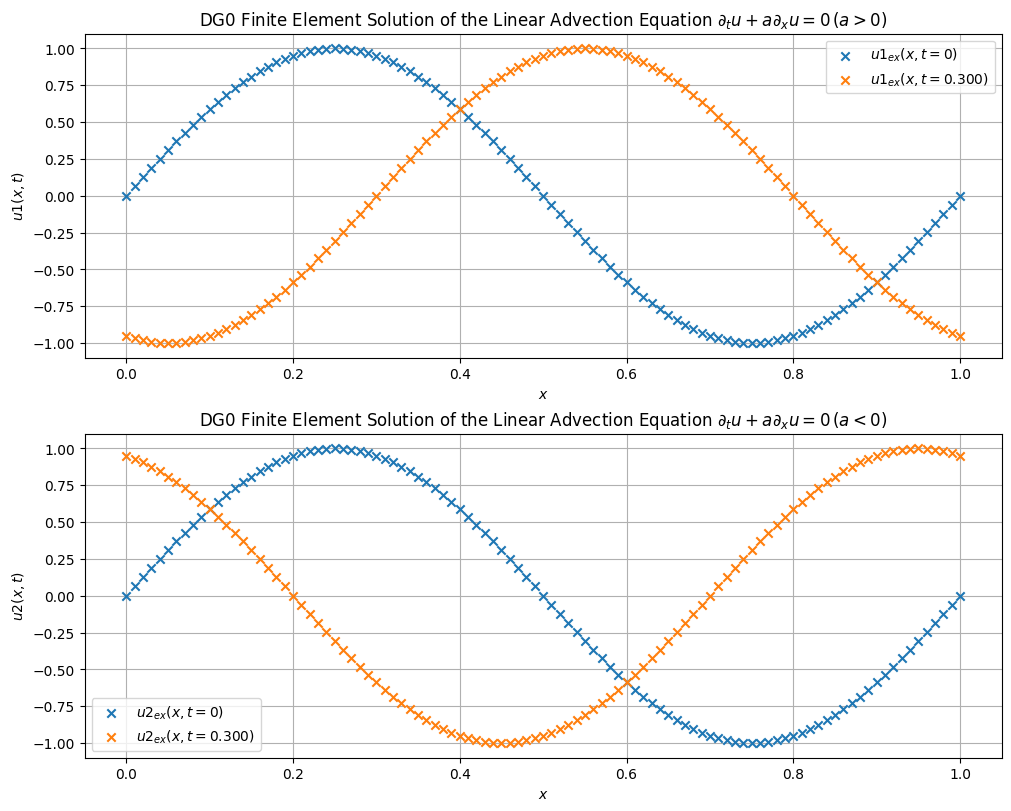

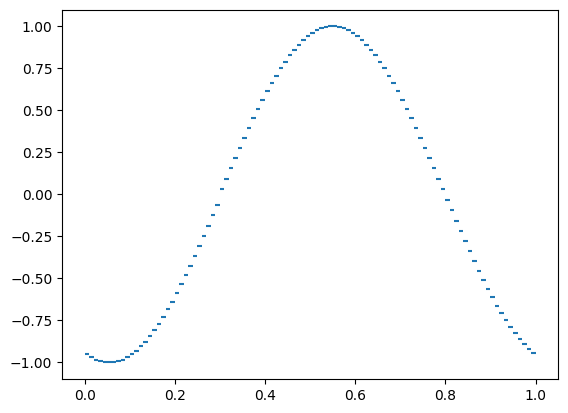

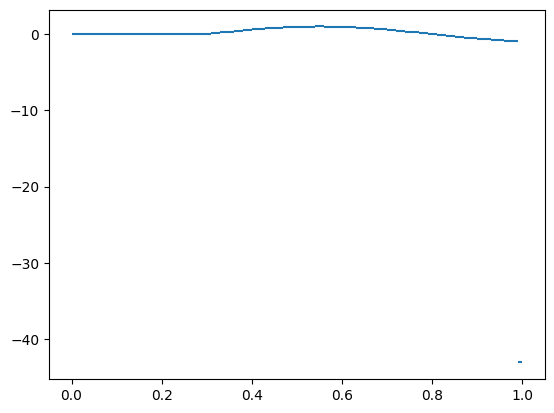

In [2]:
# Solve the linear advection equation d_t u + a d_x u = 0 (a>0) in [x0,x1] using FEM-DG0
# Initial conditions:
# 	(a) Riemann problem u0(x) = ul,  x < x_mid; ur,  x >=x_mid
# 	(b) traveling wave u0(x) = sin(2*pi*x/Lx)
# Boundary condition: specify upwind boundary value u(x0,t) for t>0
# Visualisation of results:
# - Discrete exact solutions are plotted at grid points using matplotlab,
# - Numerical solutions are plotted using Firedarke built-in plotting function.

from firedrake import *
import matplotlib.pyplot as plt
from firedrake.pyplot import plot
import numpy as np

#                              E_k
#          x0                |<--->|                       x1
#       ---|-----|-----|-----|-----|-----|-----|-----|-----|---> x
#         x_0   x_1   ...  x_k-1  x_k  x_k+1  ...  x_Nx-1 x_Nx   <= grid points  

# === discretisation ===
Lx = 1 # length of the interval
x0 = 0 # x in [x0,x1]
x1 = x0+Lx
Nx = 100 # number of elements
mesh_size = Lx/Nx # uniform grid, DO NOT USE dx!!!

x_k=np.linspace(x0,x1,num=Nx+1) # grid points, k=0,1,...,Nx, for point-wise plot of exact solutions
#https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.IntervalMesh
mesh = IntervalMesh(Nx,Lx)


a = 1.0
a_left = -a
t0 = 0
Tend = 0.5
CFL = 1.0 # in [0,1]
dt = CFL*(mesh_size/a) # time step
dtc = Constant(dt)

# === define function space and Firedrake Functions ===
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
nx = FacetNormal(mesh)[0]
an = 0.5*(a * nx + abs(a * nx))
print(an)

u1_ = Function(V) # previous time-step solution
u1 = Function(V)  # current time-step solution
u2_ = Function(V) # previous time-step solution
u2 = Function(V)  # current time-step solution
u1_trial = TrialFunction(V)
u2_trial = TrialFunction(V)
w1 = TestFunction(V)
w2 = TestFunction(V)

# === set initial condition ===
IC = "b"

if IC == "a":
    u0_l=5
    u0_r=2
    x_mid=(x0+x1)*0.5-1e-8 # shift a bit to avoid the ambiguity at the discontinous point
    u0_k = np.where(x_k < x_mid, u0_l, u0_r)     # numpy array
    u0 = conditional(lt(x[0],x_mid), u0_l, u0_r) # UFL expression
    u_in = Constant(u0_l)   # inflow boundary condition
elif IC == "b":
    #equation 1
    u10_k = np.sin(2*np.pi*x_k/Lx)  # numpy array
    u10 = sin(2*pi*x[0]/Lx)         # UFL expression
    u1_x0 = np.sin(2*np.pi*x0/Lx-(2*np.pi*a/Lx)*(t0+dt))
    u1_in = Constant(u1_x0)   # inflow boundary condition
    
    #equation 2
    u20_k = np.sin(2*np.pi*x_k/Lx)  # numpy array
    u20 = sin(2*pi*x[0]/Lx)         # UFL expression
    u2_x1 = np.sin(2*np.pi*x1/Lx-(2*np.pi*a_left/Lx)*(t0+dt))
    u2_in = Constant(u2_x1)   # inflow boundary condition

u1_.interpolate(u10)
u2_.interpolate(u20)

# plot IC with Firedrake's built-in plotting function "plot" for 1D Firedrake Function
# https://www.firedrakeproject.org/firedrake.pyplot.html#firedrake.pyplot.plot
#fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
#line0, = plot(u1_, axes=ax, label=r'$u_0(x)$')   # plot DG0 FE approximation
#line0.set_color('black')

#fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
#line1, = plot(u2_, axes=ax, label=r'$u_0(x)$')   # plot DG0 FE approximation
#line1.set_color('black')

#breakpoint()
#ax.scatter(x_k, u0_k, color='red', marker='.', label=r'$u_{ex},t=0$')  # plot exact solution at grid points

# === construct the linear solver ===
F1_in  = a * u1_in     # flux at the left boundary, inflow BC
F1_out = a * u1_       # flux at the right boundary, outflow/open BC
F2_in  = a_left * u2_in     # flux at the left boundary, inflow BC
F2_out = a_left * u2_       # flux at the right boundary, outflow/open BC
#F_int = a * u_('+')  # Godunov flux at the interior facets, turns out to be the simplified form
F1_int = an('+')*u1_('+') - an('-')*u1_('-') # general form
F2_int = an('+')*u2_('+') - an('-')*u2_('-') # general form
# "Note that there is no guaranteed relationship between the global x coordinate and the facet orientations.
# It can be different from one facet to the next." (--DH)

au1 = w1 * u1_trial * dx
au2 = w2 * u2_trial * dx
Lu1 = (w1 * u1_ * dx + 
      dtc * (  w1 * F1_in * ds(1)    # inflow boundary integral, ds(1) stands for the left boundary
             - w1 * F1_out * ds(2)    # outflow boundary integral, ds(2) stands for the right boundary
             - (w1('+') - w1('-')) * F1_int * dS ))   # Godunov flux used for the interior facets
Lu2 = (w2 * u2_ * dx + 
      dtc * (  w2 * F2_in * ds(2)    # inflow boundary integral, ds(1) stands for the left boundary
             - w2 * F2_out * ds(1)    # outflow boundary integral, ds(2) stands for the right boundary
             - (w2('+') - w2('-')) * F2_int * dS ))   # Godunov flux used for the interior facets

problem1 = LinearVariationalProblem(au1, Lu1, u1)
solver1 = LinearVariationalSolver(problem1)
problem2 = LinearVariationalProblem(au2, Lu2, u2)
solver2 = LinearVariationalSolver(problem2)

t = t0 # start time
step = 0
t_output = 0.3 # < Tend
output_step = int(t_output/dt)

# === time marching ===
while t < Tend-0.5*dt:
	# update time-dependent boundary condition
    if IC=="b":
        u1_in.assign(sin(2*pi*x0/Lx-(2*pi*a/Lx)*(t+dt))) 
        u2_in.assign(sin(2*pi*x1/Lx-(2*pi*a_left/Lx)*(t+dt)))
	
    solver1.solve()
    u1_.assign(u1)
    solver2.solve()
    u2_.assign(u2)

    step += 1
    t += dt
	
	# check intermediate result at t=t_plot
    if step == output_step:
        fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8),constrained_layout=True)
        print("t=",t)
        if IC=="a":
        	ut_k = np.where(x_k-a*t < x_mid, u0_l, u0_r)
        elif IC=="b":
            ut_k1 = np.sin(2*np.pi*x_k/Lx-(2*np.pi*a/Lx)*t)
            ut_k2 = np.sin(2*np.pi*x_k/Lx-(2*np.pi*a_left/Lx)*t)
        ax1.scatter(x_k, u10_k, marker='x', label=fr'$u1_{{ex}}(x,t=0)$') 
        ax1.scatter(x_k, ut_k1, marker='x', label=fr'$u1_{{ex}}(x,t={t:.3f})$') 
        plot(u1, label=fr'$u_{{num}}(x,t={t:.3f})$')
        ax2.scatter(x_k, u20_k, marker='x', label=fr'$u2_{{ex}}(x,t=0)$') 
        ax2.scatter(x_k, ut_k2, marker='x', label=fr'$u2_{{ex}}(x,t={t:.3f})$') 
        plot(u2, label=fr'$u_{{num}}(x,t={t:.3f})$')
        ax1.set_title(r'DG0 Finite Element Solution of the Linear Advection Equation $\partial_t u + a \partial_x u = 0 \, (a > 0)$')
        ax1.set_xlabel(r'$x$')
        ax1.set_ylabel(r'$u1(x,t)$')
        ax1.grid(True)
        ax1.set_axisbelow(True)
        ax1.legend()  
        ax2.set_title(r'DG0 Finite Element Solution of the Linear Advection Equation $\partial_t u + a \partial_x u = 0 \, (a < 0)$')
        ax2.set_xlabel(r'$x$')
        ax2.set_ylabel(r'$u2(x,t)$')
        ax2.grid(True)
        ax2.set_axisbelow(True)
        ax2.legend() 

        
plt.show()

My next task was to then change the code from a simple system of 2 linear advection equations to the shallow water system given in the assignment. To try and understand the code a bit better I started with the case of a riemann problem for the initial condition with extrapolating Boundary conditions.

t= 0.3000000000000001


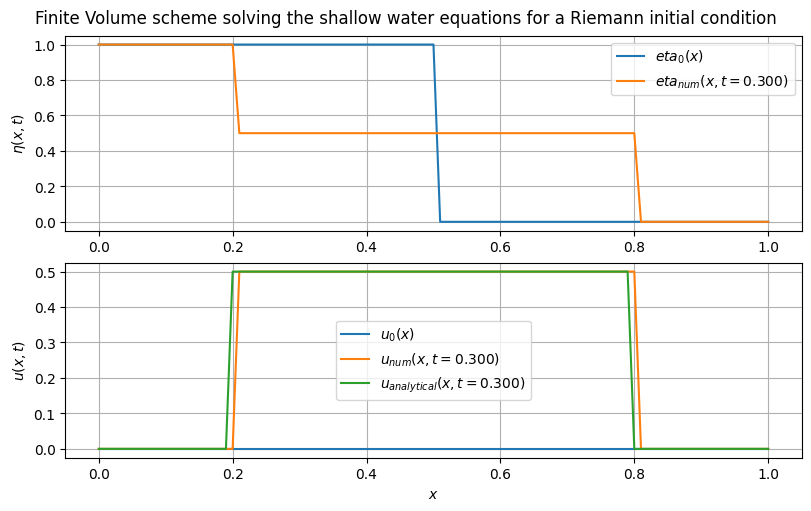

In [12]:
# Solve the linear advection equation d_t u + a d_x u = 0 (a>0) in [x0,x1] using FEM-DG0
# Initial conditions:
# 	(a) Riemann problem u0(x) = ul,  x < x_mid; ur,  x >=x_mid
# 	(b) traveling wave u0(x) = sin(2*pi*x/Lx)
# Boundary condition: specify upwind boundary value u(x0,t) for t>0
# Visualisation of results:
# - Discrete exact solutions are plotted at grid points using matplotlab,
# - Numerical solutions are plotted using Firedarke built-in plotting function.
#%%
from firedrake import *
import matplotlib.pyplot as plt
from firedrake.pyplot import plot
import numpy as np

#                              E_k
#          x0                |<--->|                       x1
#       ---|-----|-----|-----|-----|-----|-----|-----|-----|---> x
#         x_0   x_1   ...  x_k-1  x_k  x_k+1  ...  x_Nx-1 x_Nx   <= grid points  

# === discretisation ===
Lx = 1 # length of the interval
x0 = 0 # x in [x0,x1]
x1 = x0+Lx
Nx = 100 # number of elements
mesh_size = Lx/Nx # uniform grid, DO NOT USE dx!!!

x_k=np.linspace(x0,x1,num=Nx+1) # grid points, k=0,1,...,Nx, for point-wise plot of exact solutions
#https://www.firedrakeproject.org/firedrake.html#firedrake.utility_meshes.IntervalMesh
mesh = IntervalMesh(Nx,Lx)

a = 1.0 
H0 = 1.0
g = 1.0
c0 = np.sqrt(H0*g) # wave speed
t0 = 0 # time t=0
Tend = 0.5 # total time domain
CFL = 1 # in [0,1], choose CFL = 1
dt = CFL*(mesh_size/np.sqrt(H0*g)) # time step
dtc = Constant(dt) # define as constants to keep Firedrake happy

# === define function space and Firedrake Functions ===
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
nx = FacetNormal(mesh)[0]
an = 0.5*(a * nx + abs(a * nx))

# functions for u velocity
u_ = Function(V) # previous time-step solution
u = Function(V)  # current time-step solution
u_trial = TrialFunction(V)
w = TestFunction(V)

# functions for eta surface height
eta_ =  Function(V) # previous height solution
eta = Function(V)  # current time-step solution
eta__trial = TrialFunction(V)
eta__test = TestFunction(V)

# === set initial condition ===
IC = "a"

if IC == "a":
	u0_l=0
	u0_r=0
	x_mid=(x0+x1)*0.5-1e-8 # shift a bit to avoid the ambiguity at the discontinous point
	u0_k = np.where(x_k < x_mid, u0_l, u0_r)     # numpy array
	u0 = conditional(lt(x[0],x_mid), u0_l, u0_r) # UFL expression
	u_in = Constant(-u0_l)   # inflow boundary condition
    
	eta0_l=1
	eta0_r=0
	eta0_k = np.where(x_k < x_mid, eta0_l, eta0_r)     # numpy array
	eta0 = conditional(lt(x[0],x_mid), eta0_l, eta0_r) # UFL expression
	eta_in = Constant(eta0_l)   # inflow boundary condition 
    
elif IC == "b":
	u0_k = np.sin(2*np.pi*x_k/Lx)  # numpy array
	u0 = sin(2*pi*x[0]/Lx)         # UFL expression
	u_x0 = np.sin(2*np.pi*x0/Lx-(2*np.pi*g/Lx)*(t0+dt))
	u_in = Constant(u_x0)   # inflow boundary condition
    
	eta0_k = np.sin(2*np.pi*x_k/Lx)  # numpy array
	eta0 = sin(2*pi*x[0]/Lx)         # UFL expression
	eta_x0 = np.sin(2*np.pi*x0/Lx-(2*np.pi*H0/Lx)*(t0+dt))
	eta_in = Constant(eta_x0)

u_.interpolate(u0)
eta_.interpolate(eta0)

### PLOT IC ###

fig, ax = plt.subplots(2, figsize=(8, 5), layout='constrained')
eta12 = np.array([eta_.at(x) for x in x_k]) # eta12 = np.array([eta0.at(x) for x in xvals])
ax[0].plot(x_k, eta12, label=r'$eta_0(x)$')
phi12 = np.array([u_.at(x) for x in x_k])
ax[1].plot(x_k, phi12,  label=r'$u_0(x)$')


### FLUXES ###
# === construct the linear solver ===

# bounduary
F_1in  = Constant(0)  # flux at the left boundary, inflow BC
F_1out = H0 * u_       # flux at the right boundary, outflow/open BC
F_2in  = (-H0*u_in +  c0*eta_in)*g/(c0)    # flux at the left boundary, inflow BC
F_2out = g*eta_

# internal
F1_int = (H0*(u_('-') + u_('+')) - c0*((eta_('-') - eta_('+'))))/2.0
F2_int = (H0*(u_('+') - u_('-')) + c0*((eta_('-') + eta_('+'))))*g/(2.0*c0)


aeta = eta__test*eta__trial*dx
Leta =  (eta__test * eta_ * dx + 
      dtc * (  eta__test * F_1in * ds(1)    # inflow boundary integral, ds(1) stands for the left boundary
             - eta__test * F_1out * ds(2)    # outflow boundary integral, ds(2) stands for the right boundary
             - (eta__test('+') - eta__test('-')) * F1_int * dS ))

au = w * u_trial * dx
Lu = (w * u_ * dx + 
      dtc * (  w * F_2in * ds(1)    # inflow boundary integral, ds(1) stands for the left boundary
             - w * F_2out * ds(2)    # outflow boundary integral, ds(2) stands for the right boundary
             - (w('+') - w('-')) * F2_int * dS ))   # Godunov flux used for the interior facets

problem1 = LinearVariationalProblem(aeta, Leta, eta)
solver1 = LinearVariationalSolver(problem1)


problem2 = LinearVariationalProblem(au, Lu, u)
solver2 = LinearVariationalSolver(problem2)

t = t0 # start time
step = 0
t_output = 0.3 # < Tend
output_step = int(t_output/dt)
def u_analytical (x,t,x_mid,ul,ur,etal,etar, H0, c0):
    if x < x_mid -c0*t:
        return ul
    elif x < x_mid +  c0*t and x> x_mid -c0*t:
        return (H0*(ul + ur) + c0*(etal - etar))/(2.0*H0)
    elif x > x_mid + c0*t:
        return ur

# === time marching ===
while t < Tend-0.5*dt:
	# update time-dependent boundary condition
	if IC=="b":
		u_in.assign(sin(2*pi*x0/Lx-(2*pi*g/Lx)*(t+dt))) 
		eta_in.assign(sin(2*pi*x0/Lx-(2*pi*H0/Lx)*(t+dt))) 
		
	solver1.solve()
	solver2.solve()

	u_.assign(u)
	eta_.assign(eta)

	step += 1
	t += dt
	
	# check intermediate result at t=t_plot
	if step == output_step:
		print("t=",t)
		if IC=="a":
			ut_k = np.where(x_k-a*t < x_mid, u0_l, u0_r)
			etat_k = np.where(x_k-a*t < x_mid, eta0_l, eta0_r)
		elif IC=="b":
			ut_k = np.sin(2*np.pi*x_k/Lx-(2*np.pi*a/Lx)*t)
		
		eta12 = np.array([eta_.at(x) for x in x_k]) 
		ax[0].plot(x_k, eta12, label=fr'$eta_{{num}}(x,t={t:.3f})$')
		phi12 = np.array([u_.at(x) for x in x_k])
		ax[1].plot(x_k, phi12, label=fr'$u_{{num}}(x,t={t:.3f})$')
		u_real_sol = [u_analytical (x,t,x_mid,u0_l,u0_r,eta0_l,eta0_r, H0, c0) for x in x_k]
		ax[1].plot(x_k, u_real_sol, label=fr'$u_{{analytical}}(x,t={t:.3f})$')

fig.suptitle('Finite Volume scheme solving the shallow water equations for a Riemann initial condition')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u(x,t)$')
ax[0].set_ylabel(r'$\eta(x,t)$')
ax[0].grid(True)
ax[1].grid(True)
# ax.set_axisbelow(True)
ax[0].legend()
ax[1].legend()          

plt.show()


# %%
